# Training the FNO to Solve the 1D Wave Equation

# Task 1


In [16]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam,AdamW,RAdam
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)
np.random.seed(0)

In [17]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class SpatialPositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_length=10000):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_length = max_length

    def forward(self, x):
        position = x.unsqueeze(-1)  # Shape: (batch_size, grid_size, 1, 1)

        div_term = torch.exp(
            torch.arange(0, self.embedding_dim, 2, dtype=torch.float32, device=x.device) *
            (-math.log(self.max_length) / self.embedding_dim)
        )

        embeddings = torch.zeros(*position.shape[:-1], self.embedding_dim, device=x.device)

        embeddings[..., 0::2] = torch.sin(position * div_term)
        embeddings[..., 1::2] = torch.cos(position * div_term)
        
        return embeddings


In [18]:

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        self.modes1 = modes
        self.width = width
        self.layers = 128
        self.embedding_dim = 0
        #self.padding = 1  # pad the domain if input is non-periodic
        #self.linear_p = nn.Linear(1+self.embedding_dim, self.width) 
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.dropout = nn.Dropout(p=0.5)

        #self.spatial_embedding = SpatialPositionalEmbedding(self.embedding_dim)

        # Spectral layers
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect4 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect5 = SpectralConv1d(self.width, self.width, self.modes1)
        #self.spect6 = SpectralConv1d(self.width, self.width, self.modes1)

        # Conv1D layers
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)
        self.lin3 = nn.Conv1d(self.width, self.width, 1)
        self.lin4 = nn.Conv1d(self.width, self.width, 1)
        #self.lin5 = nn.Conv1d(self.width, self.width, 1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(self.width)
        self.bn2 = nn.BatchNorm1d(self.width)
        self.bn3 = nn.BatchNorm1d(self.width)
        self.bn4 = nn.BatchNorm1d(self.width)
        self.bn5 = nn.BatchNorm1d(self.width)
        #self.bn6 = nn.BatchNorm1d(self.width)

        # Linear transformations
        self.linear_q = nn.Linear(self.width, self.layers)
        self.output_layer = nn.Linear(self.layers, 1)

        self.activation = torch.nn.GELU()

    def fourier_layer(self, x, spectral_layer, conv_layer, batch_norm):
        # Apply spectral layer, Conv1D, and BatchNorm
        x = spectral_layer(x) + conv_layer(x)
        x = batch_norm(x)  # Apply Batch Normalization
        return self.activation(x)

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        #space = self.spatial_embedding(x[:,:,1])
        #print(x[:,:,0].unsqueeze(-1).shape)
        #print(space.shape)
        #x = torch.cat((x[:,:,0].unsqueeze(-1),space),dim=-1)
        #print(x.shape)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)  # Change to (batch, width, grid)

        # Apply Fourier layers with Batch Normalization
        x = self.fourier_layer(x, self.spect1, self.lin0, self.bn1)
        #x = self.dropout(x)
        x = self.fourier_layer(x, self.spect2, self.lin1, self.bn2)
        #x = self.dropout(x)
        x = self.fourier_layer(x, self.spect3, self.lin2, self.bn3)
        #x = self.dropout(x)
        x = self.fourier_layer(x, self.spect4, self.lin3, self.bn4)
        #x = self.dropout(x)
        x = self.fourier_layer(x, self.spect5, self.lin4, self.bn5)
        #x = self.fourier_layer(x, self.spect6, self.lin5, self.bn6)

        x = x.permute(0, 2, 1)  # Back to (batch, grid, width)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


## Dataset preparation

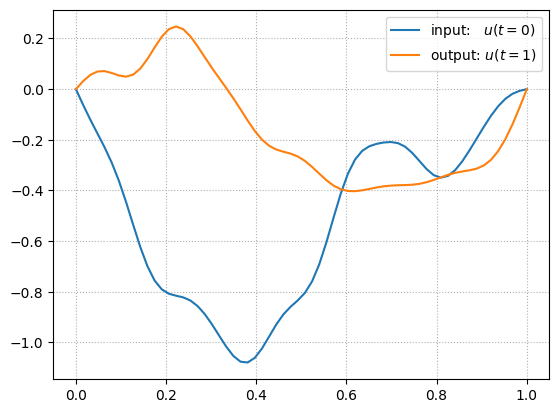

In [19]:
num_elements = 128
training_sample = 64
mesh_size = 64

# Load the data
path_train = "FNO - Wave Equation/train_sol.npy"
data = torch.from_numpy(np.load(path_train)).type(torch.float32)

#split into training and validation
random_indices = np.random.choice(num_elements, training_sample, replace=False)
training_dataset_task1 = data[random_indices, :, :]

validation_indices = np.setdiff1d(np.arange(num_elements), random_indices)
validation_dataset_task1 = data[validation_indices, :, :]

#split initial and final condition
input_train = training_dataset_task1[:,0, :].unsqueeze(-1)
target_train = training_dataset_task1[:,-1, :].unsqueeze(-1)
input_validation = validation_dataset_task1[:,0, :].unsqueeze(-1)
target_validation = validation_dataset_task1[:,-1, :].unsqueeze(-1)

#add spatial mesh to the tensor
x = torch.linspace(0, 1, mesh_size).unsqueeze(0).repeat(training_sample, 1).unsqueeze(-1)  
input_train_withspace = torch.cat((input_train, x), dim=-1)
input_validation_withspace = torch.cat((input_validation, x), dim=-1)

plt.plot(input_train_withspace[0,:,1],input_train_withspace[0,:,0], label = "input:   $u(t = 0)$")
plt.plot(input_train_withspace[0,:,1],target_train[0,:,0], label = "output: $u(t = 1)$")
plt.grid(True, which="both", ls=":")
plt.legend()

## Training the FNO

In [20]:
batch_size = 64

training_set = DataLoader(TensorDataset(input_train_withspace, target_train), batch_size=batch_size, shuffle=True)
validation_set = DataLoader(TensorDataset(input_validation_withspace, target_validation), batch_size=batch_size, shuffle=False)

learning_rate = 0.001
epochs = 10000
step_size = 1000
gamma = 0.5

modes = 16
width = 64
fno = FNO1d(modes, width)

In [21]:
optimizer = AdamW(fno.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
#l = nn.L1Loss()
freq_print = 50
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        #print(input_batch.shape, output_batch.shape)
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        #print("Predicted shape:", output_pred_batch.shape)
        #print("Target shape:", output_batch.squeeze(2).shape)
        loss_f = l(output_pred_batch, output_batch.squeeze(2))
        loss_f.backward()
        optimizer.step()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(fno.parameters(), max_norm=1.0)
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(validation_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean(torch.norm(output_pred_batch - output_batch.squeeze(2), p=2)) / torch.norm(output_batch.squeeze(2),p=2)) * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(validation_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)



######### Epoch: 0  ######### Train Loss: 0.045062050223350525  ######### Relative L2 Test Norm: 104.81565856933594
######### Epoch: 50  ######### Train Loss: 0.018387477844953537  ######### Relative L2 Test Norm: 80.31095123291016
######### Epoch: 100  ######### Train Loss: 0.006160398945212364  ######### Relative L2 Test Norm: 45.29316329956055
######### Epoch: 150  ######### Train Loss: 0.001636357745155692  ######### Relative L2 Test Norm: 24.754070281982422
######### Epoch: 200  ######### Train Loss: 0.00038194473017938435  ######### Relative L2 Test Norm: 15.262246131896973
######### Epoch: 250  ######### Train Loss: 0.00016093630983959883  ######### Relative L2 Test Norm: 11.540058135986328
######### Epoch: 300  ######### Train Loss: 7.05298880347982e-05  ######### Relative L2 Test Norm: 8.71636962890625
######### Epoch: 350  ######### Train Loss: 4.881777203991078e-05  ######### Relative L2 Test Norm: 7.668741226196289
######### Epoch: 400  ######### Train Loss: 3.2031050068326

In [32]:
#save nn if needed
#torch.save(fno.state_dict(), "fno_wave_equationnew.pth")
fno.load_state_dict(torch.load("fno_wave_equationnew.pth"))

/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_25995/4139303687.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fno.load_state_dict(torch.load("fno_wave_equa

<All keys matched successfully>

## Testset preparation + error on testset + 1 plot


Relative L2 error:  2.6008739471435547


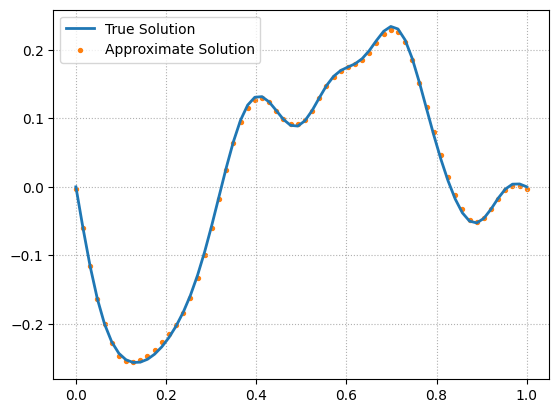

In [33]:
test_path = "FNO - Wave Equation/test_sol.npy"
data_test = torch.from_numpy(np.load(test_path)).type(torch.float32)
num_test = len(data_test)

#split initial and final condition
input_test= data_test[:,0, :].unsqueeze(-1)
target_test = data_test[:,-1, :]

#add spatial mesh to the tensor
x = torch.linspace(0, 1, mesh_size).unsqueeze(0).repeat(num_test, 1).unsqueeze(-1)  
input_test_withspace = torch.cat((input_test, x), dim=-1)

# forward pass on the testset
with torch.no_grad():
    output_function_test_pred_n = fno(input_test_withspace).squeeze(2)

plt.figure()
plt.grid(True, which="both", ls=":")

function = 10

plt.plot(input_test_withspace[0,:,1], target_test[function,:], label="True Solution", c="C0", lw=2)
plt.scatter(input_test_withspace[0,:,1], output_function_test_pred_n[function,:], label="Approximate Solution", s=8, c="C1")
#p = 2
#err = (torch.mean(abs(output_function_test_pred_n - target_test) ** p) / torch.mean(abs(target_test) ** p)) ** (1 / p) * 100
err = (torch.mean(torch.norm(output_function_test_pred_n - target_test, p=2)) / torch.norm(target_test,p=2)) * 100
print("Relative L2 error: ", err.item())
plt.legend()


## Task 2

## Testset preparation

In [47]:
test_path_32 = "FNO - Wave Equation/test_sol_res_32.npy"
test_path_64 = "FNO - Wave Equation/test_sol_res_64.npy"
test_path_96 = "FNO - Wave Equation/test_sol_res_96.npy"
test_path_128 = "FNO - Wave Equation/test_sol_res_128.npy"

data_test_32 = torch.from_numpy(np.load(test_path_32)).type(torch.float32)
data_test_64 = torch.from_numpy(np.load(test_path_64)).type(torch.float32)
data_test_96 = torch.from_numpy(np.load(test_path_96)).type(torch.float32)
data_test_128 = torch.from_numpy(np.load(test_path_128)).type(torch.float32)

assert len(data_test_32)==len(data_test_64)
assert len(data_test_64)==len(data_test_96)
assert len(data_test_96)==len(data_test_128)

num_test = len(data_test_128)

res_vet = [32,64,96,128]
err_vet = []

### 32

Relative L2 error:  13.061986923217773


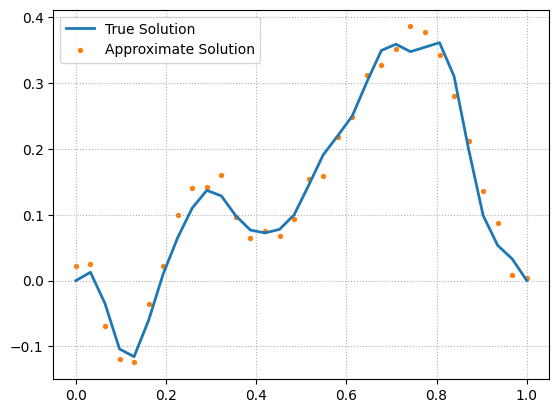

In [48]:
mesh_size = 32

#split initial and final condition
input_test_32 = data_test_32[:,0, :].unsqueeze(-1)
target_test_32 = data_test_32[:,-1, :]

#add spatial mesh to the tensor
x = torch.linspace(0, 1, mesh_size).unsqueeze(0).repeat(num_test, 1).unsqueeze(-1)  
input_test_withspace_32 = torch.cat((input_test_32, x), dim=-1)

with torch.no_grad():
    output_function_test_pred_n_32 = fno(input_test_withspace_32).squeeze(2)
plt.figure()
plt.grid(True, which="both", ls=":")

function = 10

plt.plot(input_test_withspace_32[0,:,1], target_test_32[function,:], label="True Solution", c="C0", lw=2)
plt.scatter(input_test_withspace_32[0,:,1], output_function_test_pred_n_32[function,:], label="Approximate Solution", s=8, c="C1")
#err_32 = (torch.mean(abs(output_function_test_pred_n_32 - target_test_32) ** p) / torch.mean(abs(target_test_32) ** p)) ** (1 / p) * 100
err_32 = (torch.mean(torch.norm(output_function_test_pred_n_32 - target_test_32, p=2)) / torch.norm(target_test_32,p=2)) * 100
print("Relative L2 error: ", err_32.item())
plt.legend()

err_vet.append(err_32.item())

### 64


Relative L2 error:  3.142446756362915


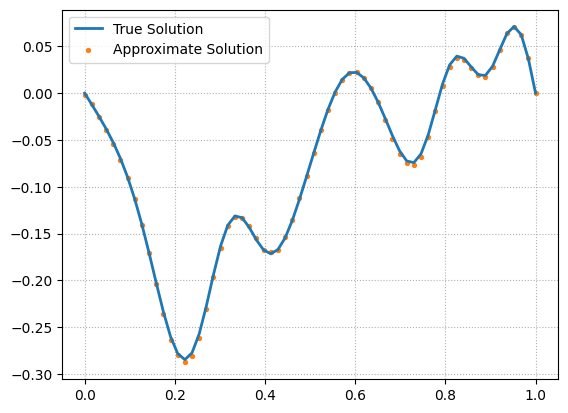

In [49]:
mesh_size = 64

#split initial and final condition
input_test_64 = data_test_64[:,0, :].unsqueeze(-1)
target_test_64 = data_test_64[:,-1, :]

#add spatial mesh to the tensor
x = torch.linspace(0, 1, mesh_size).unsqueeze(0).repeat(num_test, 1).unsqueeze(-1)  
input_test_withspace_64 = torch.cat((input_test_64, x), dim=-1)

with torch.no_grad():
    output_function_test_pred_n_64 = fno(input_test_withspace_64).squeeze(2)
#print(input_function_test_n[0,:,1])
plt.figure()
plt.grid(True, which="both", ls=":")

function = 10

plt.plot(input_test_withspace_64[0,:,1], target_test_64[function,:], label="True Solution", c="C0", lw=2)
plt.scatter(input_test_withspace_64[0,:,1], output_function_test_pred_n_64[function,:], label="Approximate Solution", s=8, c="C1")
p = 2
#err_64 = (torch.mean(abs(output_function_test_pred_n_64 - target_test_64) ** p) / torch.mean(abs(target_test_64) ** p)) ** (1 / p) * 100
err_64 = (torch.mean(torch.norm(output_function_test_pred_n_64 - target_test_64, p=2)) / torch.norm(target_test_64,p=2)) * 100
print("Relative L2 error: ", err_64.item())
plt.legend()

err_vet.append(err_64.item())

### 96

Relative L2 error:  3.4160523414611816


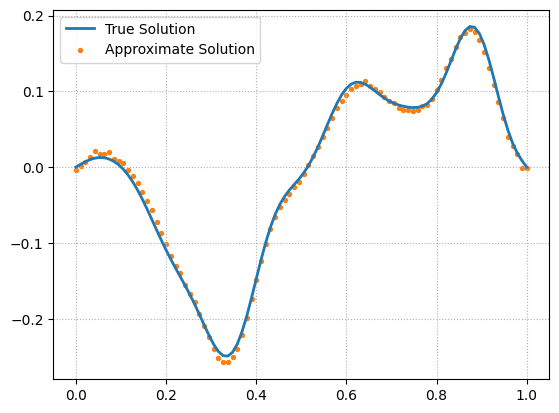

In [50]:
mesh_size = 96

#split initial and final condition
input_test_96 = data_test_96[:,0, :].unsqueeze(-1)
target_test_96 = data_test_96[:,-1, :]

#add spatial mesh to the tensor
x = torch.linspace(0, 1, mesh_size).unsqueeze(0).repeat(num_test, 1).unsqueeze(-1)  
input_test_withspace_96 = torch.cat((input_test_96, x), dim=-1)


with torch.no_grad():
    output_function_test_pred_n_96 = fno(input_test_withspace_96).squeeze(2)

plt.figure()
plt.grid(True, which="both", ls=":")

function = 37

plt.plot(input_test_withspace_96[0,:,1], target_test_96[function,:], label="True Solution", c="C0", lw=2)
plt.scatter(input_test_withspace_96[0,:,1], output_function_test_pred_n_96[function,:], label="Approximate Solution", s=8, c="C1")
#p = 2
#err_96 = (torch.mean(abs(output_function_test_pred_n_96 - target_test_96) ** p) / torch.mean(abs(target_test_96) ** p)) ** (1 / p) * 100
err_96 = (torch.mean(torch.norm(output_function_test_pred_n_96 - target_test_96, p=2)) / torch.norm(target_test_96,p=2)) * 100
print("Relative L2 error: ", err_96.item())
plt.legend()

err_vet.append(err_96.item())

### 128

Relative L2 error:  4.116302013397217


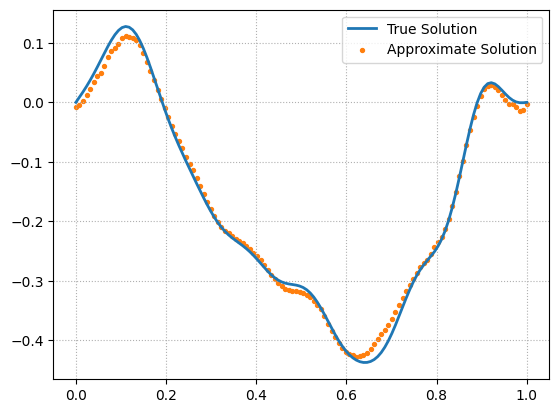

In [51]:
mesh_size = 128

#split initial and final condition
input_test_128 = data_test_128[:,0, :].unsqueeze(-1)
#print("input_shape", input_test_128.shape)
target_test_128 = data_test_128[:,-1, :]

#add spatial mesh to the tensor
x = torch.linspace(0, 1, mesh_size).unsqueeze(0).repeat(num_test, 1).unsqueeze(-1)  
input_test_withspace_128 = torch.cat((input_test_128, x), dim=-1)

with torch.no_grad():
    output_function_test_pred_n_128 = fno(input_test_withspace_128).squeeze(2)
plt.figure()
plt.grid(True, which="both", ls=":")

function = 40

plt.plot(input_test_withspace_128[0,:,1], target_test_128[function,:], label="True Solution", c="C0", lw=2)
plt.scatter(input_test_withspace_128[0,:,1], output_function_test_pred_n_128[function,:], label="Approximate Solution", s=8, c="C1")
p = 2
#err_128 = (torch.mean(abs(output_function_test_pred_n_128 - target_test_128) ** p) / torch.mean(abs(target_test_128) ** p)) ** (1 / p) * 100
err_128 = (torch.mean(torch.norm(output_function_test_pred_n_128 - target_test_128, p=2)) / torch.norm(target_test_128,p=2)) * 100
print("Relative L2 error: ", err_128.item())
plt.legend()

err_vet.append(err_128.item())

### error plot

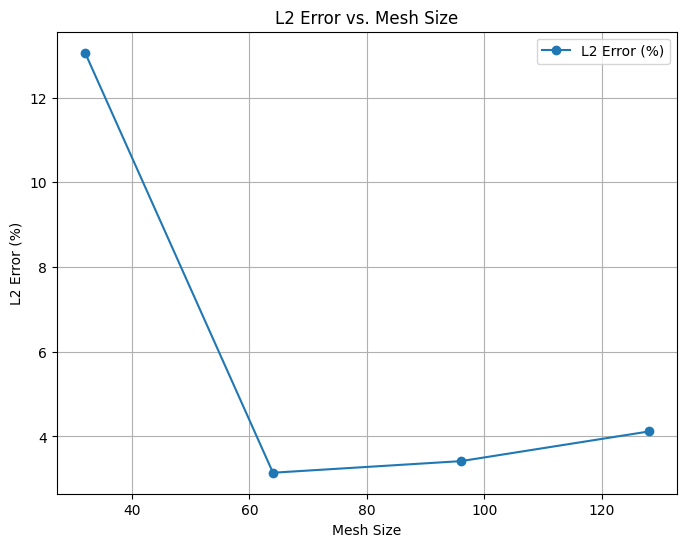

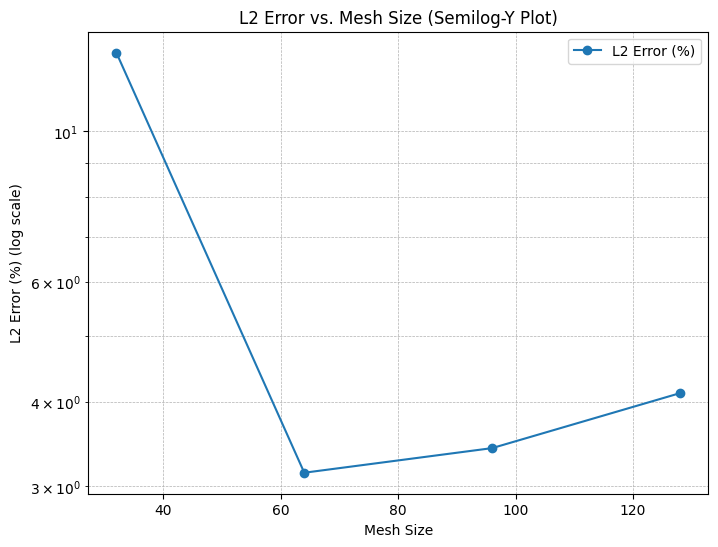

In [53]:
#print(res_vet)
#print(err_vet)

# Assuming `mesh_sizes` and `l2_errors` are your vectors
plt.figure(figsize=(8, 6))
plt.plot(res_vet, err_vet, marker='o', linestyle='-', label='L2 Error (%)')
plt.xlabel('Mesh Size')
plt.ylabel('L2 Error (%)')
plt.title('L2 Error vs. Mesh Size')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(res_vet, err_vet, marker='o', linestyle='-', label='L2 Error (%)')
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.xlabel('Mesh Size')
plt.ylabel('L2 Error (%) (log scale)')
plt.title('L2 Error vs. Mesh Size (Semilog-Y Plot)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()


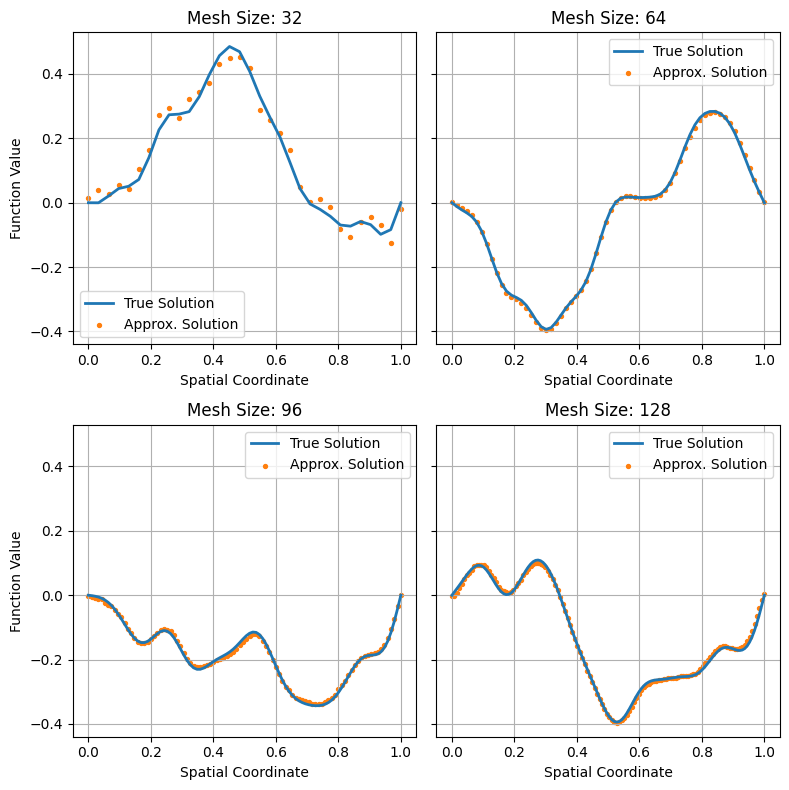

In [30]:
function = 14

# Creazione di una figura con 2x2 sottografici
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=True)

# Plot per mesh size 32
axs[0, 0].plot(input_test_withspace_32[0, :, 1], target_test_32[function, :], label="True Solution", c="C0", lw=2)
axs[0, 0].scatter(input_test_withspace_32[0, :, 1], output_function_test_pred_n_32[function, :], label="Approx. Solution", s=8, c="C1")
axs[0, 0].set_title("Mesh Size: 32")
axs[0, 0].set_xlabel("Spatial Coordinate")
axs[0, 0].set_ylabel("Function Value")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot per mesh size 64
axs[0, 1].plot(input_test_withspace_64[0, :, 1], target_test_64[function, :], label="True Solution", c="C0", lw=2)
axs[0, 1].scatter(input_test_withspace_64[0, :, 1], output_function_test_pred_n_64[function, :], label="Approx. Solution", s=8, c="C1")
axs[0, 1].set_title("Mesh Size: 64")
axs[0, 1].set_xlabel("Spatial Coordinate")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot per mesh size 96
axs[1, 0].plot(input_test_withspace_96[0, :, 1], target_test_96[function, :], label="True Solution", c="C0", lw=2)
axs[1, 0].scatter(input_test_withspace_96[0, :, 1], output_function_test_pred_n_96[function, :], label="Approx. Solution", s=8, c="C1")
axs[1, 0].set_title("Mesh Size: 96")
axs[1, 0].set_xlabel("Spatial Coordinate")
axs[1, 0].set_ylabel("Function Value")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot per mesh size 128
axs[1, 1].plot(input_test_withspace_128[0, :, 1], target_test_128[function, :], label="True Solution", c="C0", lw=2)
axs[1, 1].scatter(input_test_withspace_128[0, :, 1], output_function_test_pred_n_128[function, :], label="Approx. Solution", s=8, c="C1")
axs[1, 1].set_title("Mesh Size: 128")
axs[1, 1].set_xlabel("Spatial Coordinate")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()


# Task3

Relative L2 error:  7.509603500366211


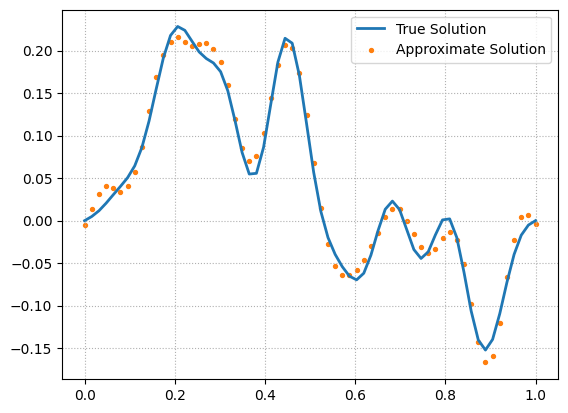

In [55]:
test_path_OOD = "FNO - Wave Equation/test_sol_OOD.npy"
data_test_OOD = torch.from_numpy(np.load(test_path_OOD)).type(torch.float32)

mesh_size = len(data_test_OOD[0,0,:])

#split initial and final condition
input_test_OOD = data_test_OOD[:,0, :].unsqueeze(-1)
target_test_OOD = data_test_OOD[:,-1, :]

#add spatial mesh to the tensor
x = torch.linspace(0, 1, mesh_size).unsqueeze(0).repeat(num_test, 1).unsqueeze(-1)  
input_test_withspace_OOD = torch.cat((input_test_OOD, x), dim=-1)

with torch.no_grad():
    output_function_test_pred_n_OOD = fno(input_test_withspace_OOD).squeeze(2)
#print(input_function_test_n[0,:,1])
plt.figure()
plt.grid(True, which="both", ls=":")

function = 31

plt.plot(input_test_withspace[0,:,1], target_test_OOD[function,:], label="True Solution", c="C0", lw=2)
plt.scatter(input_test_withspace_OOD[0,:,1], output_function_test_pred_n_OOD[function,:], label="Approximate Solution", s=8, c="C1")
p = 2
#err_OOD = (torch.mean(abs(output_function_test_pred_n_OOD - target_test_OOD) ** p) / torch.mean(abs(target_test_OOD) ** p)) ** (1 / p) * 100
err_OOD = (torch.mean(torch.norm(output_function_test_pred_n_OOD - target_test_OOD, p=2)) / torch.norm(target_test_OOD,p=2)) * 100
print("Relative L2 error: ", err_OOD.item())
plt.legend()
